In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/Sneaker Annotated Dataset.zip"

Archive:  /content/drive/My Drive/Sneaker Annotated Dataset.zip
   creating: Sneaker Annotated Dataset/black/
  inflating: Sneaker Annotated Dataset/black/0.png  
  inflating: Sneaker Annotated Dataset/black/102.png  
  inflating: Sneaker Annotated Dataset/black/105.png  
  inflating: Sneaker Annotated Dataset/black/107.png  
  inflating: Sneaker Annotated Dataset/black/112.png  
  inflating: Sneaker Annotated Dataset/black/113.png  
  inflating: Sneaker Annotated Dataset/black/116.png  
  inflating: Sneaker Annotated Dataset/black/125.png  
  inflating: Sneaker Annotated Dataset/black/126.png  
  inflating: Sneaker Annotated Dataset/black/131.png  
  inflating: Sneaker Annotated Dataset/black/144.png  
  inflating: Sneaker Annotated Dataset/black/147.png  
  inflating: Sneaker Annotated Dataset/black/152.png  
  inflating: Sneaker Annotated Dataset/black/160.png  
  inflating: Sneaker Annotated Dataset/black/166.png  
  inflating: Sneaker Annotated Dataset/black/170.png  
  inflating:

In [3]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as tfs
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from numpy import transpose, array
import torchvision.transforms.functional as TF

In [4]:
# Parameters
z_dim = 100
img_dim = 256
num_classes = 5
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
weight_decay = 1e-5
num_epochs = 300

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_embedding = nn.Embedding(num_classes, img_dim*img_dim)

        self.disc = nn.Sequential(
            nn.Conv2d(in_channels=3+1, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),

            # Shape here - 16*16*512

            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=16, stride=1, padding=0),
            # nn.Sigmoid()
        )

    def forward(self, x, label):
        label_embed = self.label_embedding(label)
        label_embed = label_embed.view(-1, 1, img_dim, img_dim)
        x = torch.cat((x, label_embed), dim=1)

        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, label_embed_size=10):
        super().__init__()

        self.label_embedding = nn.Embedding(num_classes, label_embed_size)

        self.gen = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z_dim+label_embed_size, out_channels=512, kernel_size=16, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x, label):
        label_embed = self.label_embedding(label)
        label_embed= label_embed.view(label_embed.shape[0], -1, 1, 1) # (batch_size, z_dim, 1, 1), concat along dim=1
        x = torch.cat((x, label_embed), dim=1)

        return self.gen(x)

In [6]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02) # normal distribution with mean 0 and std dev 0.02

def plot_generated_images():
    noise = torch.randn(25, z_dim, 1, 1).to(device)
    labels = torch.randint(0, num_classes, (25,), device=device)
    print(labels)
    fake = gen(noise, labels)

    # Convert tensor to PIL images and renormalize
    fake_images = [(TF.to_pil_image((img * 0.5) + 0.5)) for img in fake]

    # Plot the images
    for i in range(25):
      plt.subplot(5, 5, 1 + i)
      plt.axis('off')

      plt.imshow(fake_images[i])

    plt.savefig(f"/content/drive/My Drive/Sneaker cGAN/results_{epoch+1}.png")
    plt.show()

Folder loaded
Training started
Epoch [301/600] Loss D: 0.9855 Loss G: 0.2647
Epoch [302/600] Loss D: 0.5211 Loss G: 0.6557
Epoch [303/600] Loss D: 0.4622 Loss G: 8.8279
Epoch [304/600] Loss D: 1.6722 Loss G: 0.3871
Epoch [305/600] Loss D: 1.2758 Loss G: 8.3531
Epoch [306/600] Loss D: 1.6262 Loss G: 0.2100
Epoch [307/600] Loss D: 1.2043 Loss G: 5.7853
Epoch [308/600] Loss D: 1.5129 Loss G: 0.1761
Epoch [309/600] Loss D: 1.3532 Loss G: 4.4298
Epoch [310/600] Loss D: 1.3613 Loss G: 0.2235
Epoch [311/600] Loss D: 1.2803 Loss G: 4.3514
Epoch [312/600] Loss D: 1.3121 Loss G: 0.4493
Epoch [313/600] Loss D: 1.4715 Loss G: 4.6216
Epoch [314/600] Loss D: 1.4494 Loss G: 0.3370
Epoch [315/600] Loss D: 1.2628 Loss G: 4.3167
Epoch [316/600] Loss D: 1.2437 Loss G: 0.3761
Epoch [317/600] Loss D: 1.0512 Loss G: 4.1399
Epoch [318/600] Loss D: 1.3049 Loss G: 0.4531
Epoch [319/600] Loss D: 1.1196 Loss G: 3.9400
Epoch [320/600] Loss D: 1.1441 Loss G: 0.3383
Epoch [321/600] Loss D: 1.2329 Loss G: 3.2969
Epo

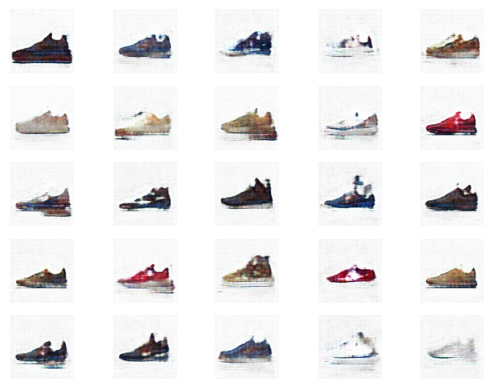

Epoch [351/600] Loss D: 0.9564 Loss G: 2.9954
Epoch [352/600] Loss D: 0.8861 Loss G: 0.4071
Epoch [353/600] Loss D: 0.7700 Loss G: 2.9765
Epoch [354/600] Loss D: 0.8128 Loss G: 0.7057
Epoch [355/600] Loss D: 0.9070 Loss G: 3.1471
Epoch [356/600] Loss D: 0.7501 Loss G: 0.8451
Epoch [357/600] Loss D: 0.8985 Loss G: 3.4731
Epoch [358/600] Loss D: 0.8308 Loss G: 0.5261
Epoch [359/600] Loss D: 0.7878 Loss G: 3.1675
Epoch [360/600] Loss D: 0.7942 Loss G: 0.5395
Epoch [361/600] Loss D: 0.7954 Loss G: 2.9510
Epoch [362/600] Loss D: 0.7947 Loss G: 0.5302
Epoch [363/600] Loss D: 0.8846 Loss G: 3.6991
Epoch [364/600] Loss D: 0.8645 Loss G: 0.6290
Epoch [365/600] Loss D: 0.9571 Loss G: 3.8643
Epoch [366/600] Loss D: 0.9118 Loss G: 0.4342
Epoch [367/600] Loss D: 0.7431 Loss G: 3.7105
Epoch [368/600] Loss D: 0.8045 Loss G: 0.4155
Epoch [369/600] Loss D: 0.9710 Loss G: 3.4831
Epoch [370/600] Loss D: 0.7596 Loss G: 0.4201
Epoch [371/600] Loss D: 0.6649 Loss G: 3.2457
Epoch [372/600] Loss D: 1.0035 Los

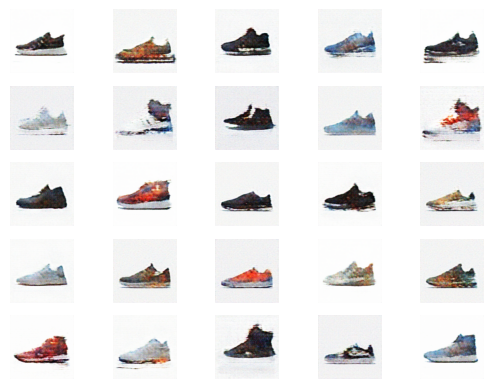

Epoch [401/600] Loss D: 0.7790 Loss G: 0.7803
Epoch [402/600] Loss D: 0.6065 Loss G: 2.9466
Epoch [403/600] Loss D: 0.6042 Loss G: 0.6966
Epoch [404/600] Loss D: 0.7290 Loss G: 3.3815
Epoch [405/600] Loss D: 0.7724 Loss G: 0.5189
Epoch [406/600] Loss D: 0.7323 Loss G: 3.8923
Epoch [407/600] Loss D: 0.6856 Loss G: 0.6103
Epoch [408/600] Loss D: 0.5796 Loss G: 2.9476
Epoch [409/600] Loss D: 0.6193 Loss G: 1.2113
Epoch [410/600] Loss D: 0.5447 Loss G: 0.6690
Epoch [411/600] Loss D: 0.5955 Loss G: 3.1404
Epoch [412/600] Loss D: 0.8529 Loss G: 0.4304
Epoch [413/600] Loss D: 0.5828 Loss G: 3.0037
Epoch [414/600] Loss D: 0.5180 Loss G: 1.0914
Epoch [415/600] Loss D: 0.5756 Loss G: 3.3898
Epoch [416/600] Loss D: 0.8141 Loss G: 0.5278
Epoch [417/600] Loss D: 0.6142 Loss G: 3.1864
Epoch [418/600] Loss D: 0.7455 Loss G: 0.5817
Epoch [419/600] Loss D: 0.6085 Loss G: 3.3395
Epoch [420/600] Loss D: 0.6602 Loss G: 0.7137
Epoch [421/600] Loss D: 0.5568 Loss G: 2.2319
Epoch [422/600] Loss D: 0.8351 Los

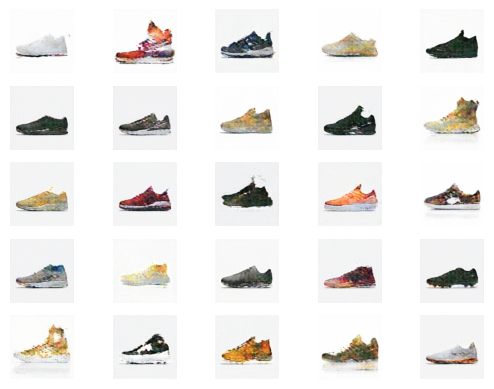

Epoch [451/600] Loss D: 0.6279 Loss G: 3.5180
Epoch [452/600] Loss D: 0.8564 Loss G: 0.6241
Epoch [453/600] Loss D: 0.4480 Loss G: 2.4090
Epoch [454/600] Loss D: 0.4877 Loss G: 1.2289
Epoch [455/600] Loss D: 0.6434 Loss G: 3.3405
Epoch [456/600] Loss D: 0.3999 Loss G: 1.4271
Epoch [457/600] Loss D: 0.7500 Loss G: 4.9459
Epoch [458/600] Loss D: 0.6063 Loss G: 0.7905
Epoch [459/600] Loss D: 0.5341 Loss G: 3.2679
Epoch [460/600] Loss D: 0.6233 Loss G: 1.0934
Epoch [461/600] Loss D: 0.6215 Loss G: 4.0330
Epoch [462/600] Loss D: 1.0643 Loss G: 0.7348
Epoch [463/600] Loss D: 0.4728 Loss G: 2.6913
Epoch [464/600] Loss D: 0.5301 Loss G: 1.1289
Epoch [465/600] Loss D: 0.5014 Loss G: 2.8327
Epoch [466/600] Loss D: 0.4480 Loss G: 1.3715
Epoch [467/600] Loss D: 0.5736 Loss G: 3.7825
Epoch [468/600] Loss D: 0.8201 Loss G: 0.6689
Epoch [469/600] Loss D: 0.7525 Loss G: 5.0808
Epoch [470/600] Loss D: 0.4599 Loss G: 1.0784
Epoch [471/600] Loss D: 0.6718 Loss G: 5.3300
Epoch [472/600] Loss D: 0.6371 Los

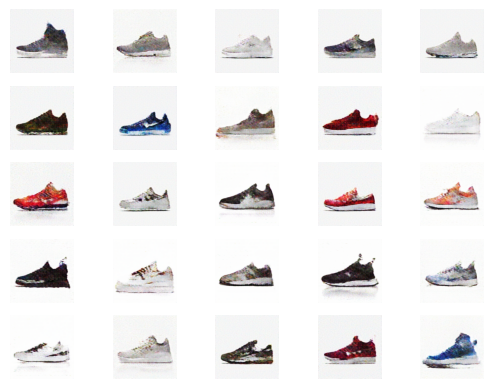

KeyboardInterrupt: 

In [9]:
gen = torch.load("/content/drive/My Drive/Sneaker cGAN/model_300.pt").to(device) # resume training
disc = torch.load("/content/drive/My Drive/Sneaker cGAN/disc_model_300.pt").to(device)

transform = tfs.Compose(
    [
        tfs.Resize(img_dim),
        tfs.ToTensor(),
        tfs.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        # mean and std of 0.5 normalizes between [-1, 1]. applied to all 3 channels
    ]
)

# Load dataset
dataset = ImageFolder(root="/content/Sneaker Annotated Dataset", transform=transform)
loader = DataLoader(dataset, batch_size=256, shuffle=True)
print("Folder loaded")

# Initialize gen and disc
gen = Generator(label_embed_size=10).to(device)
disc = Discriminator().to(device)
# initialize_weights(gen)
# initialize_weights(disc)

# Initialize optimizer
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=weight_decay)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=weight_decay)

# Loss functions
loss_fn = nn.BCEWithLogitsLoss() # combination of sigmoid and BCE loss, more numerically stable

gen.train()
disc.train()

print("Training started")

for epoch in range(num_epochs, num_epochs*2):
    for i, (images, labels) in enumerate(loader):
        real = images.to(device)
        batch_size = real.size(0)

        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise, labels.to(device))

        disc_real = disc(real.detach(), labels.to(device))
        disc_fake = disc(fake.detach(), labels.to(device))
        disc_loss = (loss_fn(disc_real, torch.ones_like(disc_real)) + loss_fn(disc_fake, torch.zeros_like(disc_fake))) / 2

        disc_opt.zero_grad()
        disc_loss.backward()
        disc_opt.step()

        disc_fake = disc(fake, labels.to(device))
        gen_loss = loss_fn(disc_fake, torch.ones_like(disc_fake))

        gen_opt.zero_grad()
        gen_loss.backward()
        gen_opt.step()

    print(f"Epoch [{epoch+1}/{num_epochs*2}] Loss D: {disc_loss:.4f} Loss G: {gen_loss:.4f}")

    if (epoch + 1) % 50 == 0:
        plot_generated_images()
        torch.save(gen, f"/content/drive/My Drive/Sneaker cGAN/model_{epoch+1}.pt")


In [8]:
torch.save(disc, f"/content/drive/My Drive/Sneaker cGAN/disc_model_300.pt")